In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import QuantileRegressor
from random import random
from scipy.integrate import simpson
from scipy.optimize import minimize
import scipy.special as sp
import matplotlib as mpl
from matplotlib.lines import Line2D
# import sys

In [2]:
data_path = "./Data/incomes_production_1990.csv"
data = pd.read_csv(data_path)
data = data[data.columns[2::]]

In [3]:
data.head()

,id,ye,age,lnrealwg,production,realwg
0,5927,8,26,2.909477,1,18.347205
1,1830,21,39,3.206010,1,24.680417
2,5960,21,39,4.808779,1,122.581883
3,1892,18,36,2.695607,1,14.814515
4,868,22,40,2.412836,1,11.165585


In [4]:
# set seed first
np.random.seed(100)

MINIMIZE_ALGORITHM = 'Nelder-Mead'  # Nelder-Mead, other option is SLSQP
MINIMIZE_ALGORITHM_BOUNDS = 'Nelder-Mead'  # Nelder-Mead, other option is SLSQP
MINIMIZE_TOL = 1e-5  # default is 1e-4

# xlist = [i for i in range(7,25,1)]
xlist = [i for i in range(0,50,1)]
# xlist = [i/10 for i in range(70,250,1)]
# xlist = [10, 20]
qs = np.arange(0.01, 1, 0.01)
qs9 = np.arange(0.1, 1, 0.1)
# qshalf = np.arange(0.01, 0.5, 0.01)
# FIXME: how do we choose epsilon
epsilon = 0.001

solver = "highs"

def approx_g(tau, theta_tau):
    y = theta_tau / tau
    return tau * (-sp.log_expit(-y) - sp.log_expit(y))
def approx_h(tau, theta_tau):
    return theta_tau * np.tanh(theta_tau / tau)
def approx_f(tau, theta_tau):
    return (approx_g(tau, theta_tau) + approx_h(tau, theta_tau)) / 2.0

def find_starting_point(p, x, y):
    x_min = np.min(x)
    x_max = np.max(x)
    data_subset_x_min = y[x == x_min]
    data_subset_x_max = y[x == x_max]
    sp0 = np.quantile(data_subset_x_min, p)
    x_min_q = sp0
    x_max_q = np.quantile(data_subset_x_max, p)
    sp1 = (x_max_q - x_min_q) / (x_max - x_min)
    return [sp0, sp1]


def Q_regr_bounds(p, x, y, bounds, starting_point=None):
    x = np.squeeze(x)
    if not starting_point:
        starting_point = [bounds[0][0], bounds[1][0]]
    def f_(beta):
        b0, b1 = beta
        theta_tau = b0 + b1*x
        return np.mean(np.abs(y - theta_tau) + (2*p-1)*(y-theta_tau))

    theta_tau_est = minimize(f_, x0=starting_point, method=MINIMIZE_ALGORITHM_BOUNDS, bounds=bounds, tol=MINIMIZE_TOL).x
    return list(theta_tau_est)

def A_regr(p, x, y, tau, starting_point=[0, 0], approx_fun=approx_f):
    x = np.squeeze(x)
    def f_(beta):
        b0, b1 = beta
        theta_tau = b0 + b1*x
        return np.mean(approx_fun(tau, y-theta_tau) + (2*p-1)*(y-theta_tau))
    theta_tau_est = minimize(f_, x0=starting_point, method=MINIMIZE_ALGORITHM, tol=MINIMIZE_TOL).x
    return list(theta_tau_est)


def qZ(x, qs):
    return 1 - np.quantile(x, qs / 2, method="median_unbiased") / np.quantile(x, (1 + qs) / 2, method="median_unbiased")


def qD(x, qs):
    return 1 - np.quantile(x, qs / 2, method="median_unbiased") / np.quantile(x, 1 - qs / 2, method="median_unbiased")

def estimate_betas_iso_oqr(data, qs):
    x = np.array(data["x"]).reshape(-1, 1)
    y = np.array(data["y"])
    beta0s = []
    beta1s = []
    for q in qs:
        qr = QuantileRegressor(quantile=q, alpha=0, solver=solver).fit(x, y)
        beta0s.append(qr.intercept_)
        beta1s.append(qr.coef_[0])
    return([beta0s, beta1s])

def estimate_indices_iso_oqr(data, qs, xs):
    x = np.array(data["x"]).reshape(-1, 1)
    y = np.array(data["y"])
    beta0s = []
    beta1s = []
    for q in qs:
        qr = QuantileRegressor(quantile=q, alpha=0, solver=solver).fit(x, y)
        beta0s.append(qr.intercept_)
        beta1s.append(qr.coef_[0])
    beta0s_iso = IsotonicRegression().fit_transform(qs, beta0s)
    beta1s_iso = IsotonicRegression().fit_transform(qs, beta1s)
    Qs = [np.exp(beta0s_iso + beta1s_iso * x_) for x_ in xs]
#     Qs = [beta0s_iso + beta1s_iso * x_ for x_ in xs]
    qZ_preds = [qZ(Q, qs=qs) for Q in Qs]
    # use Simpson rule instead of trapezoidal due to higher accuracy
    qZI_pred = [simpson(qZ_pred, x=qs) for qZ_pred in qZ_preds]
    qD_preds = [qD(Q, qs=qs) for Q in Qs]
    qDI_pred = [simpson(qD_pred, x=qs) for qD_pred in qD_preds]

    return {"qZI": qZI_pred, "qDI": qDI_pred}

def estimate_betas_iso_approx(data, qs, approx_fun=approx_f):
    x = np.array(data["x"]).reshape(-1, 1)
    y = np.array(data["y"])
    n = data.shape[0]
    x_mean = np.mean(data['x'])
    beta25 = [i[0] for i in estimate_betas_iso_oqr(data, [0.25])]
    beta75 = [i[0] for i in estimate_betas_iso_oqr(data, [0.75])]
    tau = ((beta75[0]+beta75[1]*x_mean) - (beta25[0]+beta25[1]*x_mean))/np.sqrt(n)
    betas = [A_regr(p=qs[0], x=x, y=y, tau=tau, approx_fun=approx_fun, starting_point=[0, 0])]
    for q in qs[1:]:
        beta_regr = A_regr(p=q, x=x, y=y, tau=tau, approx_fun=approx_fun, starting_point=betas[-1])
        betas.append(beta_regr)
    betas_array = np.array(betas)
    beta0s = betas_array[:, 0]
    beta1s = betas_array[:, 1]
    beta0s_iso = IsotonicRegression().fit_transform(qs, beta0s)
    beta1s_iso = IsotonicRegression().fit_transform(qs, beta1s)
    return([beta0s, beta1s])

def estimate_indices_iso_approx(data, qs, xs, tau, approx_fun=approx_f):
    x = np.array(data["x"]).reshape(-1, 1)
    y = np.array(data["y"])

    # compute with poor starting point
    betas = [A_regr(p=qs[0], x=x, y=y, tau=tau, approx_fun=approx_fun, starting_point=[0, 0])]
    for q in qs[1:]:
        # since qs are ordered use last estimate as starting point
        beta_regr = A_regr(p=q, x=x, y=y, tau=tau, approx_fun=approx_fun, starting_point=betas[-1])
        betas.append(beta_regr)
    betas_array = np.array(betas)
    beta0s = betas_array[:, 0]
    beta1s = betas_array[:, 1]
    beta0s_iso = IsotonicRegression().fit_transform(qs, beta0s)
    beta1s_iso = IsotonicRegression().fit_transform(qs, beta1s)
#     Qs = [beta0s_iso + beta1s_iso * i for i in xs]
    Qs = [np.exp(beta0s_iso + beta1s_iso * i) for i in xs]
    qZ_preds = [qZ(Q, qs=qs) for Q in Qs]
    # use Simpson rule instead of trapezoidal due to higher accuracy
    qZI_pred = [simpson(qZ_pred, x=qs) for qZ_pred in qZ_preds]
    qD_preds = [qD(Q, qs=qs) for Q in Qs]
    qDI_pred = [simpson(qD_pred, x=qs) for qD_pred in qD_preds]

    return {"qZI": qZI_pred, "qDI": qDI_pred}

In [5]:
def compute_indices(data):
    n = data.shape[0]
    x_mean = np.mean(data['x'])
    beta25 = [i[0] for i in estimate_betas_iso_oqr(data, [0.25])]
    beta75 = [i[0] for i in estimate_betas_iso_oqr(data, [0.75])]
    tau = ((beta75[0]+beta75[1]*x_mean) - (beta25[0]+beta25[1]*x_mean))/np.sqrt(n)
    print(tau)
    iso_qr_pred = estimate_indices_iso_oqr(data, qs, xlist)
    iso_Af_pred = estimate_indices_iso_approx(data, qs, xlist, tau)
    results = [
        xlist,
        iso_qr_pred["qZI"],
        iso_qr_pred["qDI"],
        iso_Af_pred["qZI"],
        iso_Af_pred["qDI"]
    ]
    return results

def compute_indices_emp(data):
    method = 'median_unbiased'
    emp_qZI = []
    emp_qDI = []
    xs = [i for i in range(7,25,1)]
    ps = np.linspace(0, 1, 1000)[1:-1]
    for x in xs:
        X = data[data['x'] == x]
        Y = np.exp(X['y'])
        qZest = 1-np.quantile(Y, ps/2, method=method)/np.quantile(Y, (1+ps)/2, method=method)
        qDest = 1-np.quantile(Y, ps/2, method=method)/np.quantile(Y, 1-ps/2, method=method)
        qZI = np.trapz(y=qZest, x=ps)
        qDI = np.trapz(y=qDest, x=ps)
        emp_qZI.append(qZI)
        emp_qDI.append(qDI)
    return(emp_qZI, emp_qDI)

In [15]:
data_path_MD = "~/Documents/phd/Data/census2000_MD.csv"
data_path_OK = "~/Documents/phd/Data/census2000_OK.csv"
data_path_OR = "~/Documents/phd/Data/census2000_OR.csv"
data_path_TN = "~/Documents/phd/Data/census2000_TN.csv"

data_MD = pd.read_csv(data_path_MD)
data_OK = pd.read_csv(data_path_OK)
data_OR = pd.read_csv(data_path_OR)
data_TN = pd.read_csv(data_path_TN)

data_xy_MD = pd.DataFrame({'y':data_MD['lweekinc'], 'x':data_MD['exper']})
data_xy_OK = pd.DataFrame({'y':data_OK['lweekinc'], 'x':data_OK['exper']})
data_xy_OR = pd.DataFrame({'y':data_OR['lweekinc'], 'x':data_OR['exper']})
data_xy_TN = pd.DataFrame({'y':data_TN['lweekinc'], 'x':data_TN['exper']})

indices_MD = compute_indices(data_xy_MD)
indices_OK = compute_indices(data_xy_OK)
indices_OR = compute_indices(data_xy_OR)
indices_TN = compute_indices(data_xy_TN)

0.03219445992067752
0.04091325390520966
0.035359385878737604
0.027664680078519917


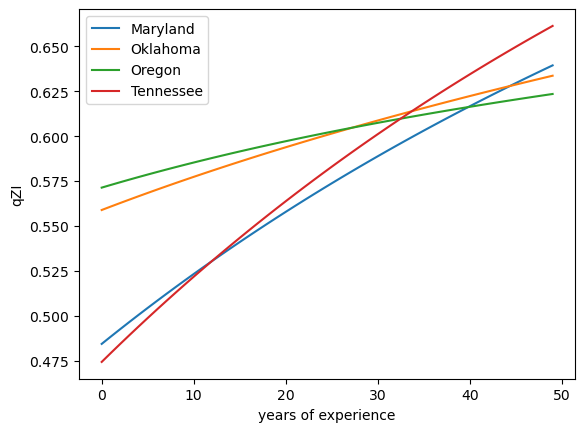

In [16]:
plt.plot(xlist, indices_MD[3])
plt.plot(xlist, indices_OK[3])
plt.plot(xlist, indices_OR[3])
plt.plot(xlist, indices_TN[3])
plt.xlabel('years of experience')
plt.ylabel('qZI')
plt.legend(['Maryland', 'Oklahoma', 'Oregon', 'Tennessee'])
filename = f'census2000_qZI.pdf'
plt.savefig(filename)

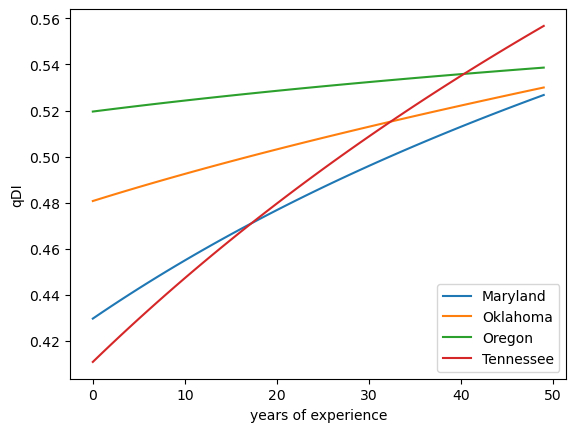

In [17]:
plt.plot(xlist, indices_MD[4])
plt.plot(xlist, indices_OK[4])
plt.plot(xlist, indices_OR[4])
plt.plot(xlist, indices_TN[4])
plt.xlabel('years of experience')
plt.ylabel('qDI')
plt.legend(['Maryland', 'Oklahoma', 'Oregon', 'Tennessee'])
filename = f'census2000_qDI.pdf'
plt.savefig(filename)

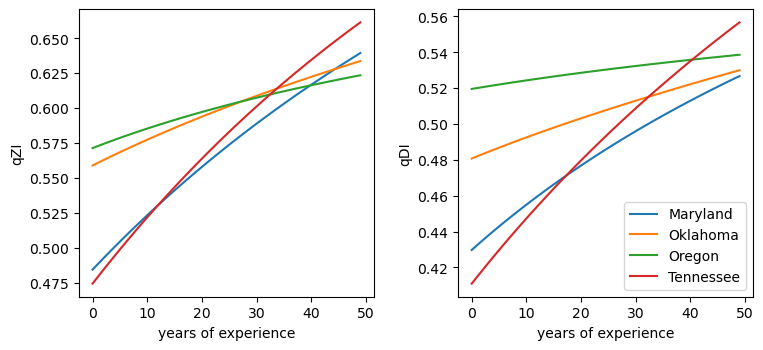

In [18]:
fig, (plt0, plt1) = plt.subplots(1, 2, figsize=(8,4), gridspec_kw={'width_ratios': [1, 1]})
fig.tight_layout(pad=3.0)

plt0.plot(xlist, indices_MD[3])
plt0.plot(xlist, indices_OK[3])
plt0.plot(xlist, indices_OR[3])
plt0.plot(xlist, indices_TN[3])
plt0.set_xlabel('years of experience')
plt0.set_ylabel('qZI')

plt.plot(xlist, indices_MD[4])
plt.plot(xlist, indices_OK[4])
plt.plot(xlist, indices_OR[4])
plt.plot(xlist, indices_TN[4])
plt1.set_xlabel('years of experience')
plt1.set_ylabel('qDI')

plt.legend(['Maryland', 'Oklahoma', 'Oregon', 'Tennessee'])
filename = f'census2000_qZI_qDI.pdf'
plt.savefig(filename)

In [19]:
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 9))

custom_lines = [Line2D([0], [0], color=cmap((9-i)/9), lw=4) for i in range(9)]

beta_0_oqr_9, beta_1_oqr_9 = estimate_betas_iso_oqr(data_xy_OK, qs9)
beta0s_iso_9 = IsotonicRegression().fit_transform(qs9, beta_0_oqr_9)
beta1s_iso_9 = IsotonicRegression().fit_transform(qs9, beta_1_oqr_9)
plt.scatter(data_xy_OK['x'], data_xy_OK['y'], s = 3)
plt.xlabel('years of experience')
plt.ylabel('log of weekly income')
xlist_OK = [i for i in range(1,np.max(data_xy_OK['x'])+3,1)]
for i in range(len(qs9)):
    plt.plot(xlist_OK, beta0s_iso_9[i] + beta1s_iso_9[i] * np.array(xlist_OK), color=colors[i])
plt.legend(custom_lines, list(np.round(qs9,2))[::-1], bbox_to_anchor=(1.3, 0.8), loc='upper right',
          title = 'order of quantile')
filename = f'log_weekly_wage_quantiles_OK.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.close()